In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.special as spsp
from statsmodels.base.model import GenericLikelihoodModel

# Setting 

We will continue studying the twenty-one game as described in Problem 1, but we will now model it as a POMDP with unobservable state components. Unlike in Problem 1, we will not assume knowledge of the underlying transition probabilities or utility function. To simplify the set of states, we will not consider usable aces. Thus, we will only have $s_1$ to $s_{10}$ for hand values 12 to 21, and $s_{11}$ for the terminal state. 

We have access to a [dataset](https://www.kaggle.com/datasets/mojocolors/900000-hands-of-blackjack-results) containing plays of actual blackjack players. The columns that will be relevant for us are as follows:

* **card1**, **card2** and **card3**: The starting cards in the player's hand.
* **card4**: The value of the card drawn, if player chose to "hit". If this is 0, then the player chose to "stop".


The **card5** column is nonzero if the player decides to "hit" a second time. If you are interested, you can experiment with incorporating these instances as additional data. We will not be asking you to do so as part of the assignment.

In [2]:
Blackjack = pd.read_csv("blkjckhands.csv")
Blackjack = Blackjack[(Blackjack["card1"] + Blackjack["card2"] + Blackjack["card3"]) > 11]
Blackjack

,PlayerNo,card1,card2,card3,card4,card5,sumofcards,winloss
0,Player1,7,10,0,0,0,17,Loss
1,Player2,10,9,0,0,0,19,Win
2,Player3,9,8,0,0,0,17,Loss
3,Player4,2,10,0,5,0,17,Loss
4,Player5,10,2,0,5,0,17,Loss
...,...,...,...,...,...,...,...,...
99997,Player2,2,8,6,10,0,26,Loss
99998,Player3,1,5,10,6,0,22,Loss
99999,Player4,10,10,0,0,0,20,Win
100000,Player5,8,11,0,0,0,19,Win


# Part 1 [12 pts]

Let's start by estimating the transition probabilities for the "hit" action. Tabulate the transition matrix by looking at the rows in which **card4** is nonzero. Then note the starting and successor states and increment the corresponding matrix value. 

If there are any 0 rows after counting everything, you should assign a 1 to the last column of those rows. This presumes that "hitting" from those states will always end in the terminal state $s_{11}$. Remember to properly normalize the matrix when finished.

Print out the estimated transition matrix when finished.

In [3]:
states = 11
def gen_P():
    P = np.zeros((states,states))
    for _, i in Blackjack[Blackjack['card4'] > 0].iterrows():
        state_i = i['card1'] + i['card2'] + i['card3'] - 12
        next = state_i + i['card4']
        if next > 10:
            next = 10
        P[state_i, next] += 1
    P[5:, -1] = 1
    return P/P.sum(axis=1).reshape(-1,1)

transitions = np.array(gen_P()) 
transitions

array([[0.        , 0.08009206, 0.07583429, 0.07445339, 0.07951669,
        0.07963176, 0.07963176, 0.07514384, 0.07640967, 0.07882624,
        0.3004603 ],
       [0.        , 0.        , 0.07786763, 0.0771189 , 0.07891584,
        0.07741839, 0.07322552, 0.08250973, 0.07861635, 0.07322552,
        0.38110213],
       [0.        , 0.        , 0.        , 0.07728119, 0.07340161,
        0.07650528, 0.07805711, 0.08147114, 0.07821229, 0.07386716,
        0.46120422],
       [0.        , 0.        , 0.        , 0.        , 0.07280335,
        0.06945607, 0.08117155, 0.07648536, 0.08217573, 0.07966527,
        0.53824268],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.07409972, 0.07704294, 0.07427285, 0.07531163, 0.08864266,
        0.61063019],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.

# Part 2 [12 pts]

Next, let's implement value iteration to solve for the $EV$ function. Remember that when we assume that latent utilities follow a Gumbel distribution, we derive 

$$EV(x,a) = \sum_{x'} \left(\log \sum_{a'} \exp\left(u(x',a') + \beta EV(x',a') \right) \right) P(x' | x,a).$$

The inputs of the value iteration function are a transition matrix (for the "hit" action), a 2D array of utility values for all state-action pairs, discount factor, and convergence threshold. The output should be a 2D array of size $11 \times 2$, same dimensions as the utilities array.

After you finish your implementation, run value iteration using $\beta=0.9$, the transition matrix learned in Part 1, and the utility function 
$$u(s_i,a_i) = \begin{cases} s_i, & s_i = 12,...,21 \text{ and } a_i = \text{``stop"} \\ 0, & \text{otherwise} \end{cases}$$

Print out the EV array when finished.

In [4]:
# Assume we can do in this way as in the lecture note
def compute_utility():
    u = np.empty((states, 2))
    for i in range(states - 1):
        u[i, 0] = i + 12
        u[i, 1] = 0
    return u
utilities = compute_utility()
utilities[-1] = 0
utilities

array([[12.,  0.],
       [13.,  0.],
       [14.,  0.],
       [15.,  0.],
       [16.,  0.],
       [17.,  0.],
       [18.,  0.],
       [19.,  0.],
       [20.,  0.],
       [21.,  0.],
       [ 0.,  0.]])

In [5]:
def value_iteration(utilities, transitions, beta, tol=1e-8):
    EV = np.zeros((states, 2))
    while True:
        new = np.empty((states, 2))
        lse = spsp.logsumexp(utilities + beta*EV, axis=1)
        new[:,1] = transitions @ lse
        new[:, 0] = lse[-1]
        if np.linalg.norm(new-EV) < tol:
            return new
        EV = new

In [6]:
beta = 0.9
EV = value_iteration(utilities, transitions, beta)
print(EV) # Sometimes I simply do EV instea of print(EV), assume both are fine

[[ 6.93147179 18.33930677]
 [ 6.93147179 17.32431963]
 [ 6.93147179 16.26072121]
 [ 6.93147179 15.18781281]
 [ 6.93147179 14.0869621 ]
 [ 6.93147179  6.93147179]
 [ 6.93147179  6.93147179]
 [ 6.93147179  6.93147179]
 [ 6.93147179  6.93147179]
 [ 6.93147179  6.93147179]
 [ 6.93147179  6.93147179]]


# Part 3 [12 pts]

We are now ready to implement the rest of the nested fixed point algorithm to estimate a utility function from the data. We will assume the following utility parameterization:
$$u(s_i, a_i) = \begin{cases} \theta_0 + \theta_1 s_i, & s_i = 12,...,21 \text{ and } a_i = \text{``hit"}  \\ \theta_2 s_i, & s_i = 12,...,21 \text{ and } a_i = \text{``stop"} \\ 0, & \text{otherwise} \end{cases}$$

We will thus be estimating three parameters in total. First implement a function that will compute and return the $11 \times 2$ array of utilities given an array containing the $\theta_i$ parameters.

Then implement a `GenericLikelihoodModel` class that can be used to estimate the parameters assuming a logistic likelihood function. When computing the log likelihood, you should first recompute the utilities using the current parameter values, followed by the $EV$ function.

In [7]:
def compute_utility(theta):
    u = np.zeros((states, 2))
    for i in range(states - 1):
        s_i = i + 12
        u[i, 1] = theta[0] + theta[1] * s_i
        u[i, 0] = theta[2] * s_i 
        #u[-1] = 0. If setting u = np.empty(states, 2) at the beginning, then uncomment this row
    return u

#theta = [1, 2, 3]
#utilities = compute_utility(theta)
#utilities

In [8]:
class NFP(GenericLikelihoodModel):
    def loglike(self, params):
        a, x = self.endog, self.exog.flatten()
        u = compute_utility(params)
        EV = value_iteration(u, transitions, beta)
        likelihood = u[x,a]+beta*EV[x,a] - spsp.logsumexp(u[x,:]+beta*EV[x,:], axis=1)
        return np.sum(likelihood)

# Part 4 [6 pts]

Now let's try and estimate a model. First you'll have to define $X$ and $y$: 
- $X$ should contain the state values, or the sum of **card1**, **card2**, and **card3** in each row. (If you will be using $X$ to index your utility array, you may want to decrement all state values by 12 first.) 
- $y$ should contain values 0 for "stop" (if **card4** is 0) or 1 for "hit" (if **card4** is nonzero).

Run your model using a discount factor of $\beta = 0.9$. To help with convergence, we recommend specifying the `bfgs` method. Show the model summary with named parameters.


In [9]:
X = Blackjack['card1'] + Blackjack['card2'] + Blackjack['card3'] - 12
y = (Blackjack['card4'] > 0).astype(int)

In [10]:
beta = 0.9
fitted = NFP(y, X).fit(start_params=np.random.random(3), method='bfgs') # or start_params = np.zeros(3) gives similar result
fitted.summary(xname=["th0", "th1", "th2"])  

Optimization terminated successfully.
         Current function value: 0.339972
         Iterations: 31
         Function evaluations: 36
         Gradient evaluations: 36


/usr/lib/python3.12/site-packages/statsmodels/base/model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/usr/lib/python3.12/site-packages/statsmodels/base/model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 NFP Results                                  
==============================================================================
Dep. Variable:                  card4   Log-Likelihood:                -33192.
Model:                            NFP   AIC:                         6.639e+04
Method:            Maximum Likelihood   BIC:                         6.641e+04
Date:                Sat, 07 Dec 2024                                         
Time:                        02:01:01                                         
No. Observations:               97631                                         
Df Residuals:                   97630                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
th0          -71.8843      2.366    -30.382      0.000     -76.522     -67.247
th1            6.4261      0.208     30.924      0.000       6.019       6.833
th2            3.2654      0.103     31.778      0.000       3.064       3.467
==============================================================================
"""

# Part 5 [8 pts]

Now take your estimated model and compute the probabilities of taking either action at each state from $s_{1}$ to $s_{10}$. Generate a plot with two curves, one showing the probability of "hitting" and the other of "stopping", both over the range of state values from 12 to 21. Please also include a legend indicating which curve is which.

Briefly explain your observations:
- How do the probabilities of each action vary with state?
- Why do some states have a decent chance of seeing either action, while others are much more certain in one action?

In [11]:
utility = compute_utility(fitted.params)
EV = value_iteration(utility, transitions, 0.9, tol=1e-8)
pro=(np.exp(utility+beta*EV).T / np.sum(np.exp(utility+beta*EV), axis=1)).T

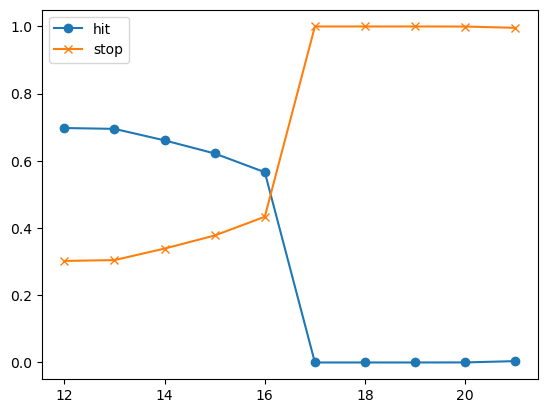

In [12]:
plt.figure()
plt.plot(range(12, 22), pro[:-1, 1], label = 'hit', marker = 'o')
plt.plot(range(12, 22), pro[:-1, 0], label = 'stop', marker = 'x')
plt.legend()
plt.show()

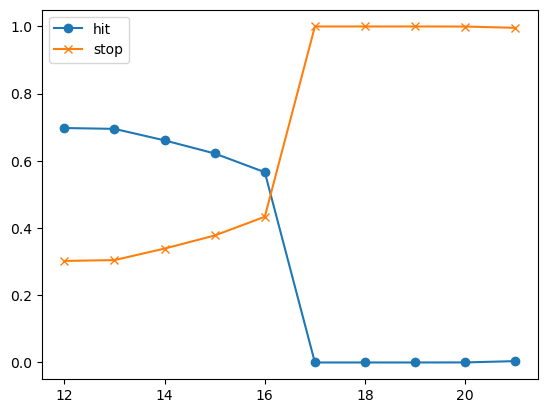

In [14]:
# or, we have, generating the same thing.
idx = np.arange(0, 11)
pro=(np.exp(utility[idx, 1]+beta*EV[idx, 1])/ np.sum(np.exp(utility[idx]+beta*EV[idx]), axis=1))
plt.figure()
plt.plot(range(12, 22), pro[:-1], label = 'hit', marker = 'o') 
plt.plot(range(12, 22), 1 - pro[:-1], label = 'stop', marker = 'x')
plt.legend()
plt.show()

- How do the probabilities of each action vary with state?

We see probablity of hit being around 0.7 at state 12 and slightly decreasing with state and then dramatically drop to around 0 starting state 16-17 and then stay near 0 or kind of increase for a tiny till state 21, while opposite for stop, kind of with probability arouunud 0.3 at state 12 at dirst then slightly increased, significant increased around state 16-17 and stay around 1 or decrease for a tiny till state 21. We might want to say this is because the significance of risk increases significantly when after state 16, causing us highly prefer stop than hit, while we reward more for hit at the states closer to 12. 

- Why do some states have a decent chance of seeing either action, while others are much more certain in one action?

This is because for states closer to state 12, reward for hit is great and risk is relatively lower, making it's preferred for hit, while still kind of considering risk so both hit and stop have a clearly non zero probability for states closer to state 12. While for states closer to state 21, stop seems better to avoid loss, or might even lost, as risk with hit is higher. Thus we see states after state 16-17, with more significant role of risk considered, stop would have significantly near 1 probability.